# Proyecto 1:
### El objetivo principal es vincular de forma automática las opiniones de la ciudadanía con los Objetivos de Desarrollo Sostenible (ODS) 1, 3 y 4
- ODS 1: Fin de la pobreza
- ODS 3: Salud Y Bienestar
- ODS 4: Educación y calidad

# Importación e Instalación de librerías

In [1]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [nltk]2/3 [nltk]


In [19]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imblearn]


In [9]:
# Manejo de Datos y Matemáticas
import numpy as np
import pandas as pd

# Visualización de Datos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Análisis Profundo de Datos (Perfilado)
from ydata_profiling import ProfileReport

# NLTK
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Scikit-learn y Skopt
import sklearn # Mantener importación general de sklearn si se usa en otras partes
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from skopt import BayesSearchCV
from skopt.space import Integer, Real

# from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [2]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/almanza33/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/almanza33/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/almanza33/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/almanza33/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/almanza33/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_da

True

# 0. Importación de los datos y Perfilamiento

In [3]:
df = pd.read_excel('./Datos_proyecto.xlsx')
df.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


Primera preocupación: No es un set de datos muy grande. Tenemos tan solo 2424 filas.

In [9]:
profile = ProfileReport(df, title="Reporte")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

De acuerdo a un perfilamiento inicial, todos nuestros textos son únicos, no tenemos textos duplicados. Por otro lado, no tenemos fields con nulos.

Tenemos un problema y es que hay una diferencia sustancial entre la cantidad de datos para las diferentes categorías. Para la ODS 4, tenemos más del doble de datos que los que poseemos para la ODS 1. El undersampling no es una opción porque de por sí ya contamos con pocos datos para todas las categorías. Por esta razón, intentaremos con Oversampling. Es decir, aumentaremos la frecuencia de muestreo de las categorías con menos datos.

# 2. Visualización y exploración de los datos
Al ser un set de datos con pocas columnas (tan solo 2, siendo una de ellas el label) todo nuestro procesamiento se concentrará en la columna de textos. Nuestro enfoque se concentrará entonces en hacer de la columna textos lo más informativa posible. Esto mediante la eliminación de ruído (StopWords y Stemming).

## 2.1 Visualización preliminar
A continuación, realizaremos una visualización de nuestro conjunto de datos mediante una nube de palabras. El tamaño de cada palabra será representativa del número de veces que aparece en el set de datos.

In [11]:
def show_wordcloud(words, stopwords=[]):
    comment_words = ""

    for val in words:
        val = str(val)
        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens) + " "

    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color="white",
        stopwords=stopwords,
        min_font_size=10,
    ).generate(comment_words)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

---------- Nube de palabras para label = 1 ----------


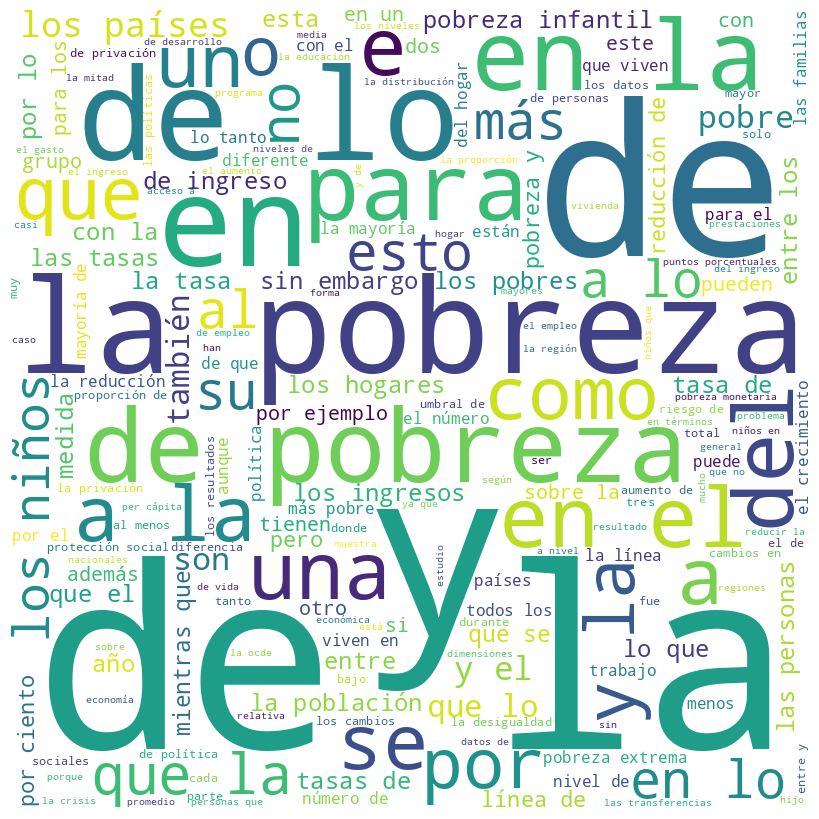

---------- Nube de palabras para label = 3 ----------


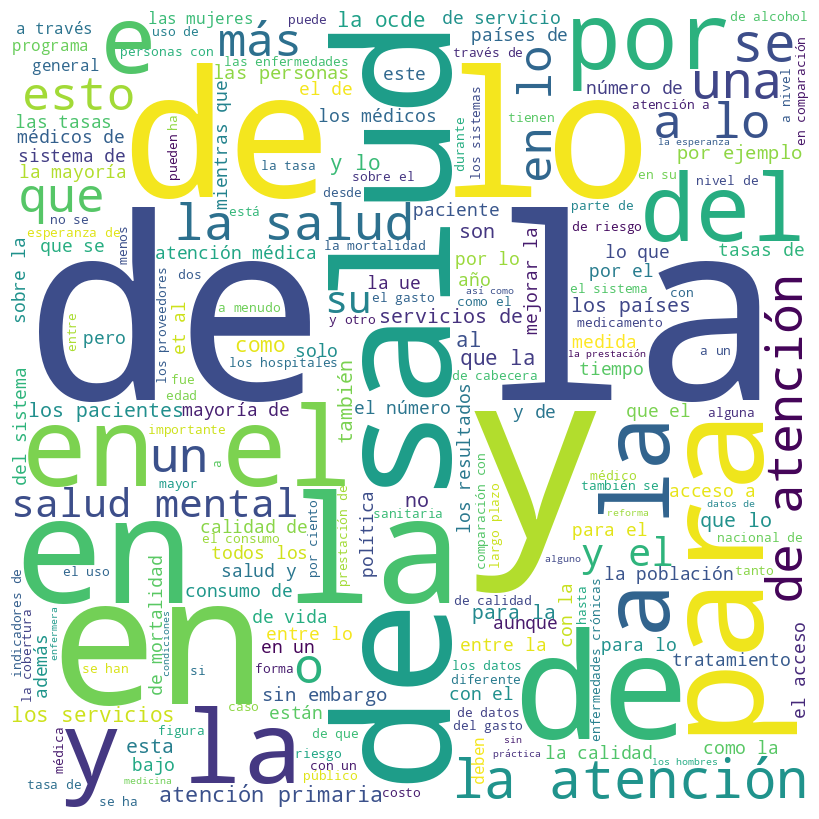

---------- Nube de palabras para label = 4 ----------


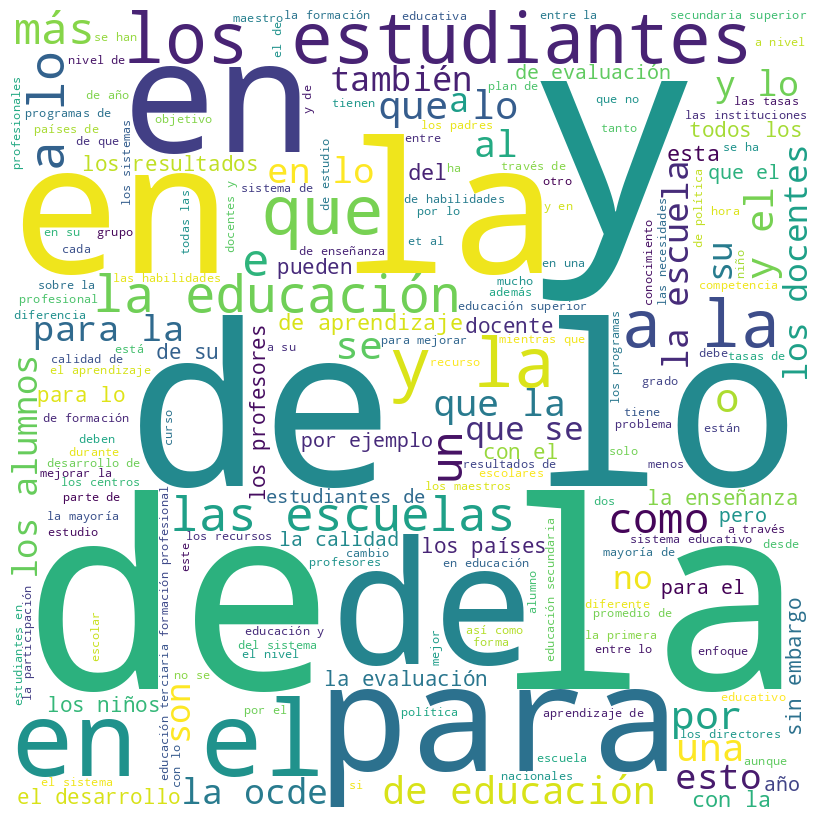

In [13]:
for i in [1,3,4]:
  print(f'---------- Nube de palabras para label = {i} ----------')
  show_wordcloud(df.loc[df['labels']==(i), 'textos'])

## STOPWORDS
Podemos mejorar los resultados de estas nubes de palabras mediante la eliminación de **StopWords**. Estos son palabras que no tienen mucha utilidad en este tipo de análisis como "de" o "la". Palabras que vemos son las más comunes en las nubes recién ploteadas.

In [16]:
STOPWORDS = set(stopwords.words("spanish"))

---------- Nube de palabras para label = 1 ----------


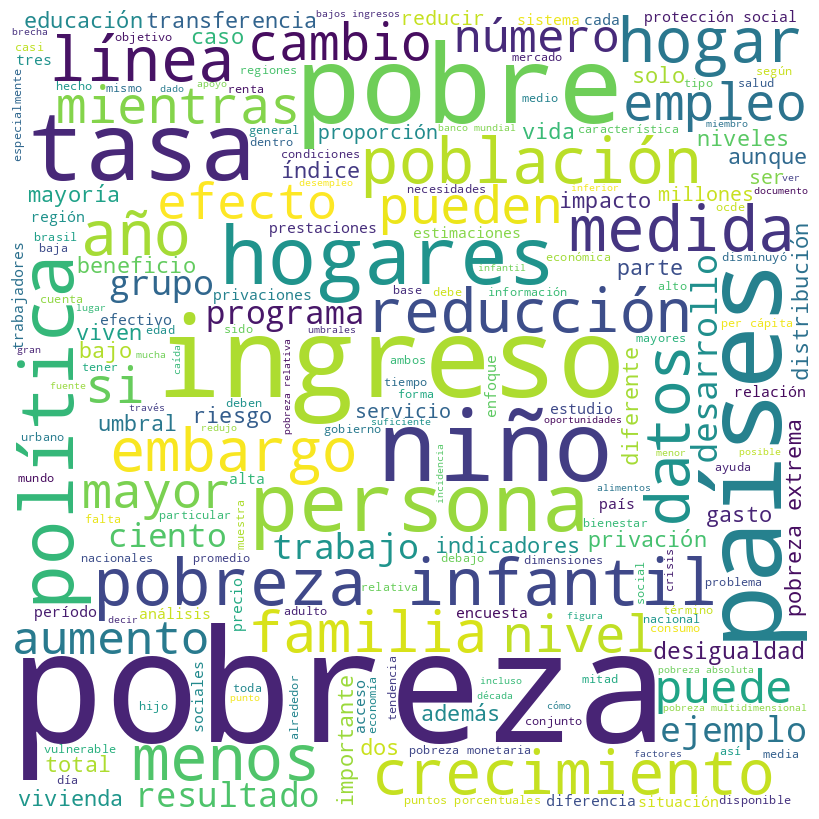

---------- Nube de palabras para label = 3 ----------


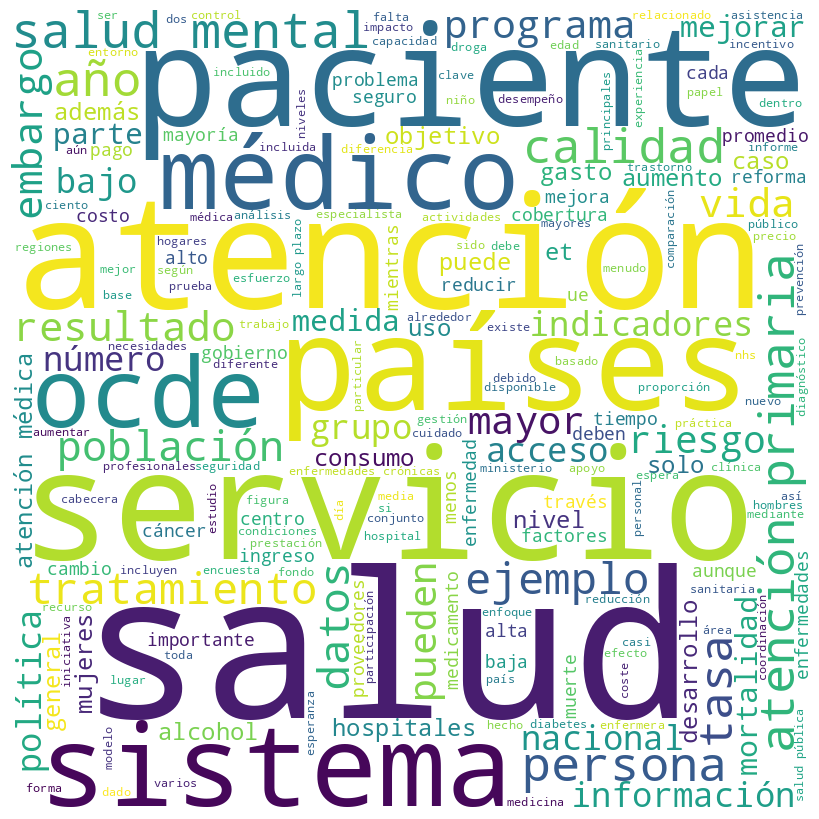

---------- Nube de palabras para label = 4 ----------


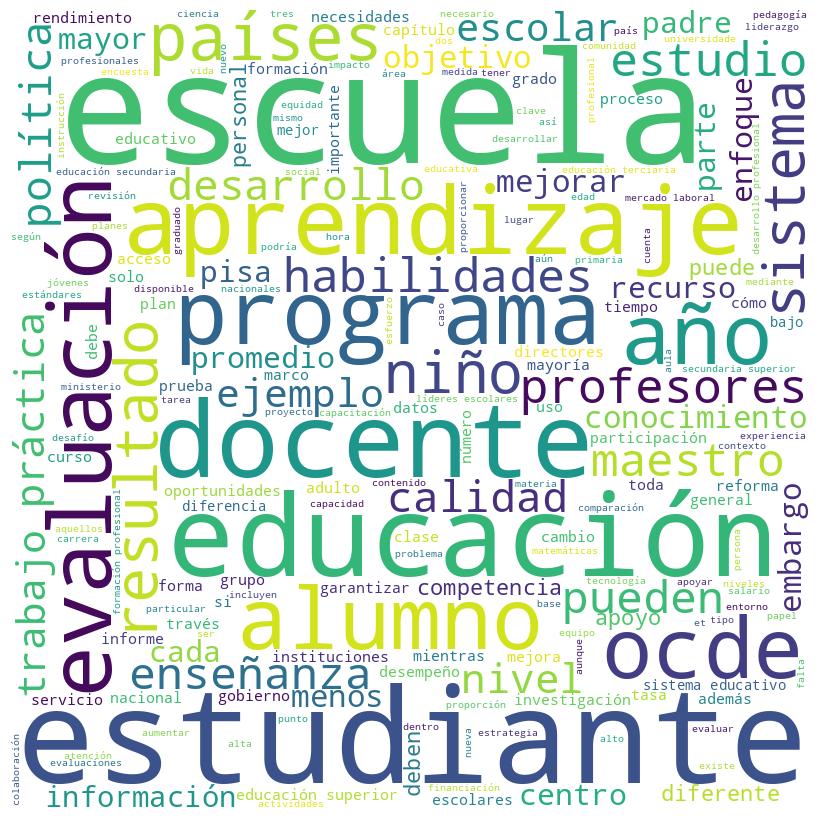

In [17]:
for i in [1,3,4]:
  print(f'---------- Nube de palabras para label = {i} ----------')
  show_wordcloud(df.loc[df['labels']==(i), 'textos'], stopwords=STOPWORDS)

Notamos que las nubes de palabras mejoran considerablemente al eliminar las StopWords. Nuestros resultados tienen sentido. Por ejemplo, para el label 4 (ODS 4, Educación y Calidad), notamos que algunos ejemplos de palabras más comunes son
- Escuela
- Estudiante
- Aprendizaje

Sin embargo, aún podemos mejorar más el procesamiento de los textos. Una técnica común en el procesamiento de lenguaje natural es el **Stemming**. Esta técnica consiste en reducir las palabras a su raíz, eliminando sufijos y prefijos. Por ejemplo, las palabras "correr", "corriendo" y "corrí" se reducirían a la raíz "corr". Esto ayuda a agrupar palabras similares y reducir la dimensionalidad del conjunto de datos.

En todo caso, haremos un primer intento de modelo sin Stemming. Evaluaremos su impacto evaluando primero sin stemming, y luego con stemming.

# 3. Inicio del modelamiento

In [5]:
X = df['textos']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train.to_frame(), y_train)

Dos cosas clave en el paso anterior:
1. Se estratificó en y a la hora de hacer la partición entre train y test. Es decir, la división se realizó manteniendo las proporciones en las que aparecía cada clase.
1. Realizamos un oversample en los datos de entrenamiento. Como discutimos antes, para lidiar con el hecho de que hay categorías bastante más comunes que otras en nuestros labels.

In [6]:
# print xTest dtype
print(X_test.dtypes)
X_test = X_test.to_frame()
print(X_test.dtypes)

object
textos    object
dtype: object


In [7]:
X_test

,textos
102,La relación entre el estatus étnico y el consu...
1220,"En los países de la OCDE, por cada reducción d..."
233,Una segunda etapa de seguimiento ocurre a los ...
2056,La persona respetable más pobre de cualquier s...
698,En ellos se basan las publicaciones anuales co...
...,...
2014,El Capítulo 4 analiza el impacto de las univer...
1429,"Sin embargo, en los últimos 40 años aproximada..."
148,"Sin embargo, MoES tiene un papel esencial que ..."
1391,Uno de los objetivos del Ministerio es preveni...


## 3.1 Modelo de Generación de vectores Binario
Decidimos comenzar con en modelo demasiado simple. Realizaremos un modelo de Bolsa de Palabras con codificación de vectores binaria. El valor de cada columna es cada palabra en nuestro diccionario. Nuestras filas son cada uno de los textos. De esta manera, un campo $c_{i,j} = 1$, donde $i$ es la columna $i$ y j es la fila $j$, si el texto $i$ contiene la palabra $j$.

Asímismo, para minimizar aún más la complejidad del modelo, no eliminaremos de él las STOPWORDS mencionadas anteriormente. Esto como ejercicio pedagógico, pues queremos posteriormente lograr el mejor modelo a nuestro alcance. Este modelo simple nos servirá entonces para medir la mejora que se puede llegar a lograr al usar diferentes técnicas de ML.

In [10]:
# Simple Binary Bag of Words Model (without stopwords removal for pedagogical purposes)

# Create binary vectorizer (no stopwords removal, simple binary encoding)
binary_vectorizer = CountVectorizer(binary=True, max_features=500)

# Fit and transform training data, transform test data
X_train_binary = binary_vectorizer.fit_transform(X_train['textos'])
X_test_binary = binary_vectorizer.transform(X_test['textos'])

# Simple Gaussian Naive Bayes classifier (no hyperparameter tuning)
simple_gnb = GaussianNB()

# Convert sparse matrices to dense for GaussianNB
X_train_binary_dense = X_train_binary.toarray()
X_test_binary_dense = X_test_binary.toarray()

# Fit the simple model
print("Entrenando modelo binario simple...")
simple_gnb.fit(X_train_binary_dense, y_train)

# Make predictions
y_pred_binary = simple_gnb.predict(X_test_binary_dense)

print("Modelo binario simple completado")
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_binary))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_binary))

Entrenando modelo binario simple...
Modelo binario simple completado

Matriz de confusión:
[[ 92   5   4]
 [ 22 154   3]
 [  8   7 190]]

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.75      0.91      0.83       101
           3       0.93      0.86      0.89       179
           4       0.96      0.93      0.95       205

    accuracy                           0.90       485
   macro avg       0.88      0.90      0.89       485
weighted avg       0.91      0.90      0.90       485



Reporte de metricas - Modelo Binario


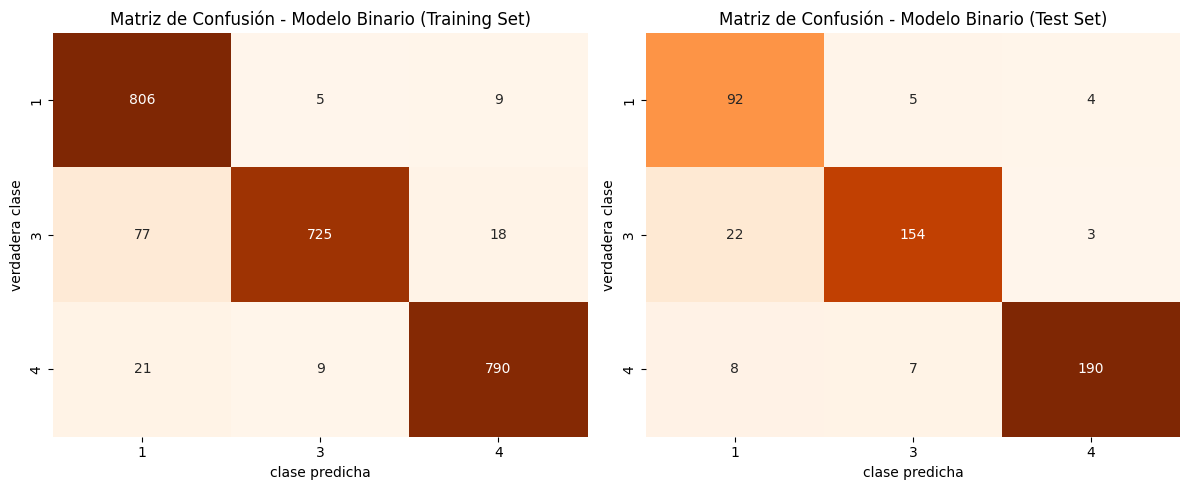


 Reporte de clasificacion - Modelo Binario (Entrenamiento):
              precision    recall  f1-score   support

           1       0.89      0.98      0.94       820
           3       0.98      0.88      0.93       820
           4       0.97      0.96      0.97       820

    accuracy                           0.94      2460
   macro avg       0.95      0.94      0.94      2460
weighted avg       0.95      0.94      0.94      2460


 Reporte de clasificacion - Modelo Binario (Test):
              precision    recall  f1-score   support

           1       0.75      0.91      0.83       101
           3       0.93      0.86      0.89       179
           4       0.96      0.93      0.95       205

    accuracy                           0.90       485
   macro avg       0.88      0.90      0.89       485
weighted avg       0.91      0.90      0.90       485



In [12]:
# Evaluate binary model results
y_train_pred_binary = simple_gnb.predict(X_train_binary_dense)
y_test_pred_binary = simple_gnb.predict(X_test_binary_dense)

print("Reporte de metricas - Modelo Binario")

cm_train_binary = confusion_matrix(y_train, y_train_pred_binary)
cm_test_binary = confusion_matrix(y_test, y_test_pred_binary)

classes = np.unique(y_train)
class_labels = [str(c) for c in classes]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train_binary, annot=True, fmt='d', cmap='Oranges', cbar=False, ax=axes[0],
            xticklabels=class_labels, yticklabels=class_labels)
axes[0].set_xlabel('clase predicha')
axes[0].set_ylabel('verdadera clase')
axes[0].set_title('Matriz de Confusión - Modelo Binario (Training Set)')

sns.heatmap(cm_test_binary, annot=True, fmt='d', cmap='Oranges', cbar=False, ax=axes[1],
            xticklabels=class_labels, yticklabels=class_labels)
axes[1].set_xlabel('clase predicha')
axes[1].set_ylabel('verdadera clase')
axes[1].set_title('Matriz de Confusión - Modelo Binario (Test Set)')

plt.tight_layout()
plt.show()

print("\n Reporte de clasificacion - Modelo Binario (Entrenamiento):")
print(classification_report(y_train, y_train_pred_binary))

print("\n Reporte de clasificacion - Modelo Binario (Test):")
print(classification_report(y_test, y_test_pred_binary))

## 3.2 Modelo Tf-IDF

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=100)

X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_test_vectorized = tfidf_vectorizer.transform(X_test)

""" n_features_vectorized = X_train_vectorized.shape[1]

n_components_to_fit = n_features_vectorized

if n_features_vectorized == 0:
    n_components_to_fit = 1

svd_analysis = TruncatedSVD(n_components=n_components_to_fit, algorithm='randomized', random_state=77)

svd_analysis.fit(X_train_vectorized)

explained_variance_ratio = svd_analysis.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

for threshold in [0.80, 0.85, 0.95]:
    if cumulative_explained_variance[-1] < threshold:
        n_components_for_threshold = len(cumulative_explained_variance)
        print(f"se necesita más de {n_components_for_threshold}para explicar {threshold:.2f} de la varianza.")
    else:
        n_components_for_threshold = np.argmax(cumulative_explained_variance >= threshold) + 1
        print(f"{n_components_for_threshold} componenetes explican {threshold:.2f} varianza.") """

' n_features_vectorized = X_train_vectorized.shape[1]\n\nn_components_to_fit = n_features_vectorized\n\nif n_features_vectorized == 0:\n    n_components_to_fit = 1\n\nsvd_analysis = TruncatedSVD(n_components=n_components_to_fit, algorithm=\'randomized\', random_state=77)\n\nsvd_analysis.fit(X_train_vectorized)\n\nexplained_variance_ratio = svd_analysis.explained_variance_ratio_\n\ncumulative_explained_variance = np.cumsum(explained_variance_ratio)\n\nfor threshold in [0.80, 0.85, 0.95]:\n    if cumulative_explained_variance[-1] < threshold:\n        n_components_for_threshold = len(cumulative_explained_variance)\n        print(f"se necesita más de {n_components_for_threshold}para explicar {threshold:.2f} de la varianza.")\n    else:\n        n_components_for_threshold = np.argmax(cumulative_explained_variance >= threshold) + 1\n        print(f"{n_components_for_threshold} componenetes explican {threshold:.2f} varianza.") '

In [42]:
spanish_stopwords = stopwords.words("spanish")

preprocessor = make_column_transformer(
    (TfidfVectorizer(stop_words=spanish_stopwords), 'textos')
)

pipeline_svd = Pipeline(
    [
        ("preprocessor", preprocessor),            
        ("svd", TruncatedSVD(random_state=77)),     
        ("gnb", GaussianNB()),                      
    ]
)

param_space_svd = {
    "gnb__var_smoothing": Real(1e-9, 1e-3, prior="log-uniform"),
    "preprocessor__tfidfvectorizer__max_features": Integer(50, 1000),
    "svd__n_components": Integer(2, 7, prior='uniform'),             
}


opt_svd = BayesSearchCV(
    pipeline_svd,
    search_spaces=param_space_svd,
    n_iter=30,
    cv=6,
    random_state=77,
    verbose=10,
    n_jobs=-1,
)

print("Iniciando búsqueda bayesiana")

opt_svd.fit(X_train, y_train)

print("Búsqueda completada")
print("Mejores hiperparámetros:")
print(opt_svd.best_params_)

print("Evaluando el modelo en el conjunto de prueba")
y_pred_svd = opt_svd.predict(X_test)

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_svd))

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_svd))


Iniciando búsqueda bayesiana
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[CV 1/6; 1/1] START gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components=4
[CV 2/6; 1/1] START gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components=4
[CV 5/6; 1/1] START gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components=4
[CV 4/6; 1/1] START gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components=4
[CV 3/6; 1/1] START gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components=4
[CV 6/6; 1/1] START gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components=4
[CV 1/6; 1/1] END gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components=4;, score=0.917 total time=   0.1s
[CV 2/6; 1/1] END gnb__var_smoothing=1.0972873793149

Reporte de metricas


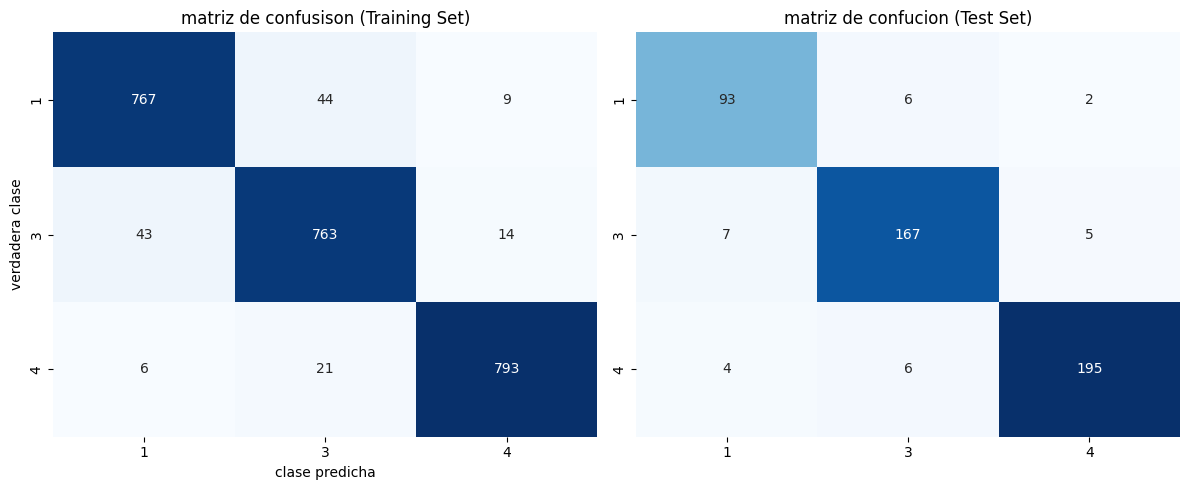


 Reporte de clasificacion (Entrenamiento):
              precision    recall  f1-score   support

           1       0.94      0.94      0.94       820
           3       0.92      0.93      0.93       820
           4       0.97      0.97      0.97       820

    accuracy                           0.94      2460
   macro avg       0.94      0.94      0.94      2460
weighted avg       0.94      0.94      0.94      2460


 Reporte de clasificacion (Test):
              precision    recall  f1-score   support

           1       0.89      0.92      0.91       101
           3       0.93      0.93      0.93       179
           4       0.97      0.95      0.96       205

    accuracy                           0.94       485
   macro avg       0.93      0.93      0.93       485
weighted avg       0.94      0.94      0.94       485



In [43]:
y_train_pred = opt_svd.predict(X_train)
y_test_pred = opt_svd.predict(X_test)


print("Reporte de metricas")

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

classes = np.unique(y_train)
class_labels = [str(c) for c in classes]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
            xticklabels=class_labels, yticklabels=class_labels)
axes[0].set_xlabel('clase predicha')
axes[0].set_ylabel('verdadera clase')
axes[0].set_title('matriz de confusison (Training Set)')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1],
            xticklabels=class_labels, yticklabels=class_labels)
axes[0].set_xlabel('clase predicha')
axes[0].set_ylabel('verdadera clase')
axes[1].set_title('matriz de confucion (Test Set)')

plt.tight_layout()
plt.show()

print("\n Reporte de clasificacion (Entrenamiento):")
print(classification_report(y_train, y_train_pred))

print("\n Reporte de clasificacion (Test):")
print(classification_report(y_test, y_test_pred))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train.to_frame(), y_train)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train['textos'])  
X_test_vec = vectorizer.transform(X_test)  

In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_vec, y_train)

In [ ]:
y_pred = rf.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)

# Mostrar la matriz en forma gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' = enteros
plt.title("Matriz de Confusión - Random Forest")
plt.show()

El modelo construido es un clasificador de texto basado en Random Forest. Lo que hace es tomar frases o documentos escritos y predecir a qué categoría pertenecen. Para lograrlo, primero convertimos los textos en vectores numéricos usando TF-IDF, una técnica que mide la importancia de cada palabra en relación con el conjunto de documentos. Además, como los datos podían estar desbalanceados (es decir, con más ejemplos de una clase que de otra), aplicamos RandomOverSampler para equilibrar las clases en el entrenamiento y evitar que el modelo favorezca siempre a la clase mayoritaria.

El entrenamiento consistió en dividir los datos en train y test, balancear los datos de entrenamiento y luego entrenar un RandomForestClassifier con 200 árboles de decisión. Una vez entrenado, evaluamos el modelo en ambos conjuntos (train y test) para comprobar tanto el aprendizaje como la capacidad de generalización. Finalmente, usamos métricas como accuracy, reporte de clasificación y matrices de confusión para ver visualmente qué tan bien predijo cada clase y si existía sobreajuste entre entrenamiento y prueba.